In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from glob import glob
import os
import re
import pyemma.msm as msm
import pyemma.coordinates as coor
import pyemma.plots as mplt
import numpy as np
import my_network_plot as myplt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import operator
import pandas as pd
import mdtraj as md
import matplotlib.image as mpimg 
import pickle
from pyemma.coordinates.clustering import KmeansClustering


# Load the data

Below is the parameters cell for papermill parameterisation:

In [46]:
traj_num = 3
root_dir = 'msm_10ps'
slice_nums = [(2, 255), (3, 902)]


In [47]:
bhmms = [pickle.load(open('bhmm_mods/{1}_state/traj_{0}-idx_{2}_bhmm.p'.format(traj_num, *x),'rb')) 
         for x in slice_nums]

In [48]:
bhmms[1].metastable_assignments

array([1, 2, 1, 0, 2, 0, 0, 2, 1, 0, 2, 2, 1, 2, 2, 0, 2, 0, 2, 0, 1, 2, 2,
       1, 1, 0, 1, 2, 2, 0, 2, 2, 2, 0, 0, 1, 0, 2, 1, 2, 1, 0, 2, 0, 2, 1,
       1, 0, 0, 1, 2, 2, 2])

In [49]:
cluster = KmeansClustering(n_clusters=1).\
    load('msm_10ps/output_3/902_dtraj_obj.pyemma')
ccs = cluster.cluster_centers_

In [59]:
idx = bhmms[1].observable_set
idx

array([ 2,  3,  7,  9, 11, 14, 16, 18, 19, 20, 28, 30, 31, 32, 33, 34, 37,
       38, 39, 40, 41, 42, 43, 45, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57,
       59, 60, 61, 64, 68, 70, 71, 73, 75, 76, 77, 78, 79, 83, 84, 86, 89,
       90, 92])

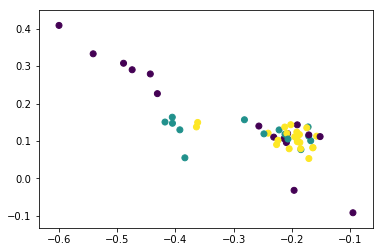

In [53]:
plt.scatter(ccs[idx, 1], ccs[idx, 2], c=bhmms[1].metastable_assignments)

In [54]:
hmm = msm.MaximumLikelihoodHMSM().load('msm_10ps/output_3/902_hmm_obj.pyemma')

In [58]:
hmm.metastable_assignments - bhmms[1].metastable_assignments

ValueError: operands could not be broadcast together with shapes (100,) (53,) 

In [14]:
lag = bhmms[0].lagtime
lag_ps = 10
dt = np.round(lag_ps/lag, 2)
dt 

0.10000000000000001

In [15]:
import numpy.linalg as la
def get_rate_matrix(T):
    # diagnonalize
    w, v = la.eig(T)
    # sort eigenvectors and eigenvalues
    order = np.argsort(w)[::-1]
    w = w[order]
    v = v[:, order]
    # create diagonal matrix
    n = len(w)
    ln_T_diag = np.eye(n)
    ln_T_diag[np.eye(n, dtype=bool)] =  np.log(w)
    # convert to original basis
    lnT = la.multi_dot((v,ln_T_diag, la.inv(v)))
    K = lnT/lag_ps
    return K

In [16]:
def plot_timescales(axes,  mm, dt, let, maxy=4388, xscale=1):
    
    ax = axes
    # Timescale plots
    ts = mm.sample_mean('timescales')*dt
    tsL,tsR = mm.sample_conf('timescales')
    tsL, tsR = tsL*dt, tsR*dt
    N = mm.nstates
    maxy = 10**(int(np.log10(maxy))+1)
    # Slow:
#     ax.plot(ts[0], 0, 1, lw=5, color='g', label='Slow')
    cols = sns.color_palette('colorblind', N-1)
    for i in range(0,N-1): 
        y = np.repeat(ts[i], 2)
        yl = np.repeat(tsL[i], 2)
        yr = np.repeat(tsR[i], 2)
        
        x = np.array([0, 1])+i
        ax.plot(x*xscale, y, lw=5, color=cols[i])
        ax.fill_between(x*xscale, yl, yr, color=cols[i], alpha=0.5)


    # Labels
    ax.set_yscale('log')
#     ax.set_ylabel('Timescales (ps)')
    
    # Tick marks for timescale plots
    locator = matplotlib.ticker.FixedLocator(locs=ts[:N], nbins=N)
    formatter = matplotlib.ticker.StrMethodFormatter('{x:3.0f} ps')
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_locator(locator)
    ax.tick_params(which='minor', labelleft=False, left=False)
    ax.tick_params(which='major', labelbottom = False, bottom=False)
    ax.set_ylim(1, maxy)
    
    formatter2 = matplotlib.ticker.FuncFormatter(lambda x, pos: '{0}'.format(int(np.log10(x))))

    ax2 = ax.twinx()
    ax2.set_ylim(1, maxy)
    ax2.set_yscale('log')
    ax2.yaxis.set_major_formatter(formatter2) 
    ax2.set_ylabel(r'$\log(\tau/ps)$', rotation=0, horizontalalignment='left', labelpad=10 )
    
    ax.annotate(s='({})(iii)'.format(let), xy=(0.05, 1.05), xycoords='axes fraction', family='Times New Roman')


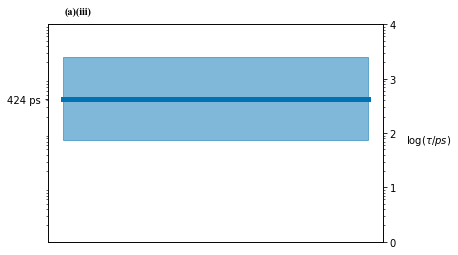

In [18]:
fig, ax = plt.subplots()
plot_timescales(ax, bhmms[0], dt, 'a')

In [19]:
def plot_network(mm, ax, let, pad=0.4):
    N = mm.nstates
    # Colors 
    cmap_use = 'viridis_r'
    cmap = matplotlib.cm.get_cmap(cmap_use,N)
    cols = [cmap(n) for n in range(N)]
    T = mm.sample_mean('transition_matrix')
    K = get_rate_matrix(T)
    ts = 1.0/K
    # Network
    r = 0.8
    shift = 1 #0*np.pi/6
    x = np.array([r * np.cos(2*np.pi*n/N + shift) for n in range(N)])
    y = np.array([r * np.sin(2*np.pi*n/N + shift) for n in range(N)])
#     delta = -0.2
    pos = np.concatenate((x[:, np.newaxis], y[:,np.newaxis]), axis=1)
    _, _ = myplt.plot_markov_model(mm.transition_matrix, ax=ax, 
                                  arrow_curvature=3.5, state_colors=cols, arrow_labels=ts, 
                                  arrow_label_format = '%2.0f ps',pos=pos,
                                  figpadding=pad, arrow_scale=0.5, state_scale=2)
    ax.annotate(s='({})(ii)'.format(let), xy=(0.3, 1.05), xycoords='axes fraction', family='Times New Roman')
    


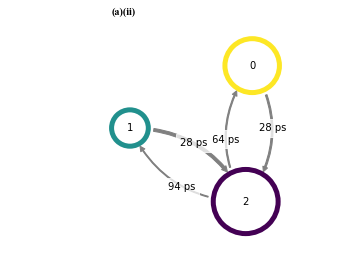

In [21]:
fig, axes = plt.subplots(1)
plot_network(bhmms[1], axes, 'a', pad=0.3)

In [22]:
def plot_image(ax, idx, let, coords, T):
    # scatter plot
    img = mpimg.imread('slice_{}_crop.tga'.format(slice_nums[idx][1]))
    ax.imshow(img)
    ax.tick_params(which='both', labelbottom=False,labelleft=False,labeltop=False,labelright=False,
                      bottom=False, left=False, top=False, right=False)
    _ = [x.set_visible(False) for x in ax.spines.values()]
    
    # Panel num
    ax.annotate(s='({})(i)'.format(let), xy=(0.05, 1.05), xycoords='axes fraction', family='Times New Roman')

    # time label
    ax.annotate(s='{} ns'.format(T), xy=(0.65, 0.9), xycoords='axes fraction')

    # Axes labels
    x1, y1 = 0.3, 0.1
    x2, y2 = 0.1, 0.3
    connectionstyle = "angle,angleA=-90,angleB=0,rad=0"
    ax.annotate("",
                xy=(x1, y1), xycoords='axes fraction',
                xytext=(x2, y2), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="<->", color='k',
                                connectionstyle=connectionstyle,lw=2,
                                ))
    ax.annotate(s=coords[0],xy=(x1*1.01, y1*0.9), xycoords='axes fraction')
    ax.annotate(s=coords[1],xy=(x2*0.9, y2*1.1), xycoords='axes fraction')
    
    


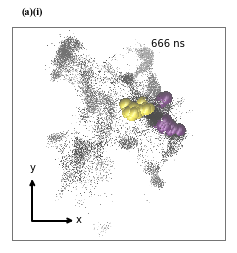

In [24]:
fig, ax = plt.subplots()
plot_image(ax,0,'a', coords=['x','y'], T=666)

# MSM plot 

In [34]:
TRAJ_LEN=1000
with sns.plotting_context('paper', font_scale=2):
    scale=5
    ncols=3
    nrows=3
#     sns.set_style(rc={'font.family':'serif', 'font.serif': 'times'})

    for idx in range(3):

        letters = ['a', 'b', 'c']
        coords = [['z', 'y'], ['-x', 'y'], ['y', 'x']]
#         idx = 1
        # Set up figure and axes

#         axes = [fig.add_subplot(gs[idx, i]) for i in range(0,ncols)]
        fig, ax = plt.subplots(1)
        plot_image(ax, idx,  letters[idx], coords=coords[idx], T=slice_nums[idx][1])
        plt.savefig('{}-1.png'.format(idx), dpi=450, bbox_inches='tight')
        plt.close()
        
        # network
        fig, ax = plt.subplots(1)
        plot_network(bhmms[idx], ax, letters[idx], pad=0.3)
        plt.savefig('{}-2.png'.format(idx), dpi=450, bbox_inches='tight')
        plt.close()

        # timescales
        fig, ax = plt.subplots(1, figsize=(3,4))
        plot_timescales(ax, bhmms[idx], dt, letters[idx], xscale=1)
        plt.savefig('{}-3.png'.format(idx), dpi=450, bbox_inches='tight')
        plt.close()

#     gs.tight_layout(fig, w_pad=0)
#     plt.savefig('traj-{0}_slices-{1}-{2}-{3}.png'.format(traj_num, *[slice_nums[i][1] for i in range(3)]), 
#                 dpi=300, bbox_inches='tight')


/Users/robertarbon/miniconda3/envs/science/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
